In [ ]:
%pip install bertopic 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import bertopic
from bertopic import BERTopic


In [ ]:
df = pd.read_csv('../data/SPOTIFY_REVIEWS_tokens.csv')

df.shape

(3308617, 13)

In [3]:
import datetime as dt
df['review_timestamp'] = pd.to_datetime(df['review_timestamp'])
df2 = df[(df['review_timestamp'] >= '2019-11-15') & (df['review_timestamp'] <= '2023-11-15')]
print("Original:", len(df))
print("After the most recent 5 year:", len(df2))

Original: 3308617
After the most recent 5 year: 1669701


In [4]:
df_final = df2[~df2['length_type'].isin(['Short', 'Very short'])].reset_index(drop=True)
print(df2['length_type'].value_counts())
print(df_final['review_rating'].value_counts())


length_type
Very short    614051
Long          587948
Short         269962
Medium        197652
Name: count, dtype: int64
review_rating
5    310410
1    248160
4     92271
3     69013
2     65834
Name: count, dtype: int64


In [5]:
df_final = df_final[~df_final['review_text'].isin(['[deleted]', '[removed]'])].reset_index(drop=True)
df_final.shape
df_final.head()

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,raw_word_count,length_type,length_type2,tokens
0,1663991,979989f1-78a2-4576-a783-c763ae7a9ffa,157768270865747512306,A Google user,I love the fact that I can listen to nearly an...,4,1,8.5.31.676,2019-11-15 00:02:50,68.0,Long,Long,"['i', 'love', 'the', 'fact', 'that', 'i', 'can..."
1,1663997,bd98f73f-1bb1-42f8-ad7a-d12f4c3662e9,280812221700598190021,A Google user,Randomly stops playing.... I will be listening...,2,2,8.5.31.676,2019-11-15 00:18:54,64.0,Long,Long,"['randomly', 'stops', 'playing', '.', '.', '.'..."
2,1663998,7167a53f-b1c0-4eae-9f33-26295c73de76,765391996510868237903,A Google user,So far this has been a better experience than ...,5,0,8.5.31.676,2019-11-15 00:19:11,22.0,Long,Long,"['so', 'far', 'this', 'has', 'been', 'a', 'bet..."
3,1664000,9fb431b7-7f2b-494c-8f0d-2805dec40b70,307958352133874143584,A Google user,Great app for looking up and listening to ur f...,5,0,NaN,2019-11-15 00:20:11,11.0,Long,Long,"['great', 'app', 'for', 'looking', 'up', 'and'..."
4,1664001,e3872654-d562-422e-96c1-d2480db446f4,180538848993703574960,A Google user,I love this app so .uch cause zi get to listen...,5,0,8.5.29.828,2019-11-15 00:20:20,18.0,Long,Long,"['i', 'love', 'this', 'app', 'so', '.', 'uc', ..."


In [6]:
import re

def light_clean(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_final['review_text_clean'] = df_final['review_text'].apply(light_clean)



In [7]:

df_mid_all = df_final[(df_final["review_rating"] == 3)]


docs_mid = df_mid_all["review_text_clean"].astype(str).tolist()


print(len(docs_mid))


69013


In [8]:
#%pip install scikit-learn
#%pip install PCA
from sklearn.decomposition import PCA
from bertopic import BERTopic

%pip install bertopic sentence-transformers umap-learn hdbscan scikit-learn



Note: you may need to restart the kernel to use updated packages.


In [10]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import umap, hdbscan
import torch

device = "cpu"
emb_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)


def build_topic_model():
    # Vectorizer: relaxed min_df/max_df so c-TF-IDF doesn't error
    vectorizer = CountVectorizer(
        ngram_range=(1, 2),              # unigrams + bigrams
        min_df=1,                        # keep words appearing in >= 1 topic-doc
        # max_df left as default (=1.0) → no conflict with min_df
        stop_words="english",
        token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"
    )

    # UMAP: dimensionality reduction
    umap_model = umap.UMAP(
        n_neighbors=10,
        n_components=3,
        min_dist=0.1,
        metric="cosine",
        n_epochs=50,
        random_state=42,
        verbose=True
    )

    # HDBSCAN: clustering
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=200,            # larger → fewer, more stable topics
        metric="euclidean",
        cluster_selection_method="eom",
        prediction_data=False
    )

    topic_model = BERTopic(
        embedding_model=emb_model,
        vectorizer_model=vectorizer,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        language="english",
        low_memory=True,
        calculate_probabilities=False,
        nr_topics=50,
        verbose=True
    )

    return topic_model






In [11]:
print("\n=== Fitting BERTopic on GOOD (5-star) reviews ===")
topic_model_mid = build_topic_model()
topics_mid, probs_mid = topic_model_mid.fit_transform(docs_mid)

topic_info_mid = topic_model_mid.get_topic_info()
print("\nMID topics (head):")
print(topic_info_mid.head())

rep_mid = topic_model_mid.get_representative_docs()


2025-11-29 22:09:15,695 - BERTopic - Embedding - Transforming documents to embeddings.



=== Fitting BERTopic on GOOD (5-star) reviews ===


Batches:   0%|          | 0/2157 [00:00<?, ?it/s]

2025-11-29 22:16:59,186 - BERTopic - Embedding - Completed ✓
2025-11-29 22:16:59,189 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


UMAP(angular_rp_forest=True, metric='cosine', n_components=3, n_epochs=50, n_jobs=1, n_neighbors=10, random_state=42, verbose=True)
Sat Nov 29 22:16:59 2025 Construct fuzzy simplicial set
Sat Nov 29 22:16:59 2025 Finding Nearest Neighbors
Sat Nov 29 22:16:59 2025 Building RP forest with 18 trees
Sat Nov 29 22:17:08 2025 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	 6  /  16
	 7  /  16
	Stopping threshold met -- exiting after 7 iterations
Sat Nov 29 22:17:21 2025 Finished Nearest Neighbor Search
Sat Nov 29 22:17:23 2025 Construct embedding


Epochs completed:   0%|            0/50 [00:00]

	completed  0  /  50 epochs
	completed  5  /  50 epochs
	completed  10  /  50 epochs
	completed  15  /  50 epochs
	completed  20  /  50 epochs
	completed  25  /  50 epochs
	completed  30  /  50 epochs
	completed  35  /  50 epochs
	completed  40  /  50 epochs
	completed  45  /  50 epochs
Sat Nov 29 22:17:44 2025 Finished embedding


2025-11-29 22:17:45,681 - BERTopic - Dimensionality - Completed ✓
2025-11-29 22:17:45,684 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid usi


MID topics (head):
   Topic  Count                                          Name  \
0     -1  24736                       -1_app_songs_song_music   
1      0    619                                0_que_la_en_se   
2      1   1061                            1_hai_lagu_saya_ke   
3      2    211  2_canvas_canvas option_canvas feature_option   
4      3  10544                     3_spotify_app_music_songs   

                                                                                                       Representation  \
0                                                 [app, songs, song, music, play, like, good, playlist, just, listen]   
1                                                                [que, la, en, se, es, el, para, las, canciones, por]   
2                                                                 [hai, lagu, saya, ke, di, bisa, na, mm, ki, kenapa]   
3  [canvas, canvas option, canvas feature, option, feature, canvas doesn, spotify canvas, account, spotif

Exception ignored in: <function ResourceTracker.__del__ at 0x104191c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106741c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106379c60>
Traceback (most recent call last

In [12]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Full topic words
topic_info_mid = topic_model_mid.get_topic_info()
display(topic_info_mid)

# Full representative documents
rep_mid = topic_model_mid.get_representative_docs()

for topic in rep_mid:
    print(f"\n=== TOPIC {topic} ===")
    for doc in rep_mid[topic]:
        print(doc)
        print("------")


,Topic,Count,Name,Representation,Representative_Docs
0,-1,24736,-1_app_songs_song_music,"[app, songs, song, music, play, like, good, playlist, just, listen]","[Good app here we can listen in songs .But we cannot download songs, I'm giving it 3 stars because if u don't get the premium thing then it will just shuffle all the songs if u don't want it to and u can't really do anything about it and it's annoying and u can only skip the songs 6 times every hour and I don't want to have to do that I want to be able to tap on a song and not have to be forced to listen to a song so pls fix this problem so I can listen to music I want to listen to, I love this app, It's an amazing app for music! I can listen to songs I can't on other apps,But the reason why I didn't do 5 stars,Is because you have to be premium,To listen to the song you like. Also you can only skip 6 times an hour, It's very irritating when you are trying to skip a song you don't like.]"
1,0,619,0_que_la_en_se,"[que, la, en, se, es, el, para, las, canciones, por]","[Es una buena aplicación en cuanto a variedad y calidad de sonido, por algo es tan sobresaliente en el mercado. Sin embargo, su oferta es bastante limitada ya que muchos artistas y canciones no las tiene o las va borrando por algún motivo. Creo que este elemento es muy importante, por lo que pierde ventaja frente a otras aplicaciones que tienen repertorios mucho mas robustos y la diferencia en precio no es significativa. Por otro lado, es muy grata la tarifa diferenciada para estudiantes., Desde hace una semana me esta dando problemas con el tema de los permisos y que tengo que darle el permiso para que pueda andar la música de fondo. Se los doy pero nADA. Apago la pantalla, me anda media canción y se para de la nada. Me fijé si era algo del celular pero nope. Tiene todos los permisos necesarios, tengo espacio, ya probé de todo pero no se soluciona :/. Ya no sé que hacer. No lo estoy pagando al premium para que me de estos problemas., la Verdad muy buena app pero algo que odio,detesto es que me reproduzca canciones que yo no quiero. Y no me deje cambiarlas cuando quiera a menos que sea premium. así no se puede escuchar canciones. osea entiendo que recomiendan otras canciones para esa playlist (me aparecen canciones que no quiero en playlist que hago) y es molesto la verdad,Quiero escuchar cosmic kid y me aparece la Joaquí nada que ver.]"
2,1,1061,1_hai_lagu_saya_ke,"[hai, lagu, saya, ke, di, bisa, na, mm, ki, kenapa]","[Aplikasinya bagus, tapi coba untuk aplikasi smartphone bisa di tambah lagu dari Local Files seperti pada aplikasi PC. Soalnya beberapa lagu favorit saya tidak ada di spotify, jadi saya selalu menambahkannya dari Local Files, tapi itu tidak bisa dilakukan untuk smartphone. Terima kasih., I like this aap but is ma ek problem hai ki agar aap premium nahi Lata toh ganna ka beach ma baar baar ads ata raha ga jo ki bohot bura lag ta hai ya problem Spotify ko thik kar ni chahiye agar bannda premium nahi la sak ta toh kya kar sakte toh Spotify valo isa hai thik kar lo please nahi toh tumhari aap bohot achi hai 👍🤐🤐, Kurang bagus karena sejak ada shuffle plat saya gak bisa mainkan lagu yang saya suka lalu tiba tiba lagu saya berubah ke lagu yang saya tidak suka]"
3,2,211,2_canvas_canvas option_canvas feature_option,"[canvas, canvas option, canvas feature, option, feature, canvas doesn, spotify canvas, account, spotify, settings]","[I has no Canvas and I try and I try and I try and I to find Canvas but it doesn't have Canvas. I would like to try you to bring my Canvas back!!!!!!, I don't have the option of Canvas ?? I am a Spotify premium user why do I not have canvas, No canvas :/ I dont have the option to turn on canvas]"
4,3,10544,3_spotify_app_music_songs,"[spotify, app, music, songs, song, play, like, love, premium, just]","[(Device: Samsung Galaxy Tab A7 Lite) I've been using Spotify as my main streaming music app. One disappointing fact is that whenever I used Spotify on my tablet, it takes very lo


=== TOPIC -1 ===
Good app here we can listen in songs .But we cannot download songs
------
I'm giving it 3 stars because if u don't get the premium thing then it will just shuffle all the songs if u don't want it to and u can't really do anything about it and it's annoying and u can only skip the songs 6 times every hour and I don't want to have to do that I want to be able to tap on a song and not have to be forced to listen to a song so pls fix this problem so I can listen to music I want to listen to
------
I love this app, It's an amazing app for music! I can listen to songs I can't on other apps,But the reason why I didn't do 5 stars,Is because you have to be premium,To listen to the song you like. Also you can only skip 6 times an hour, It's very irritating when you are trying to skip a song you don't like.
------

=== TOPIC 0 ===
Es una buena aplicación en cuanto a variedad y calidad de sonido, por algo es tan sobresaliente en el mercado. Sin embargo, su oferta es bastante limi

In [13]:
fig = topic_model_mid.visualize_topics()
fig.show()

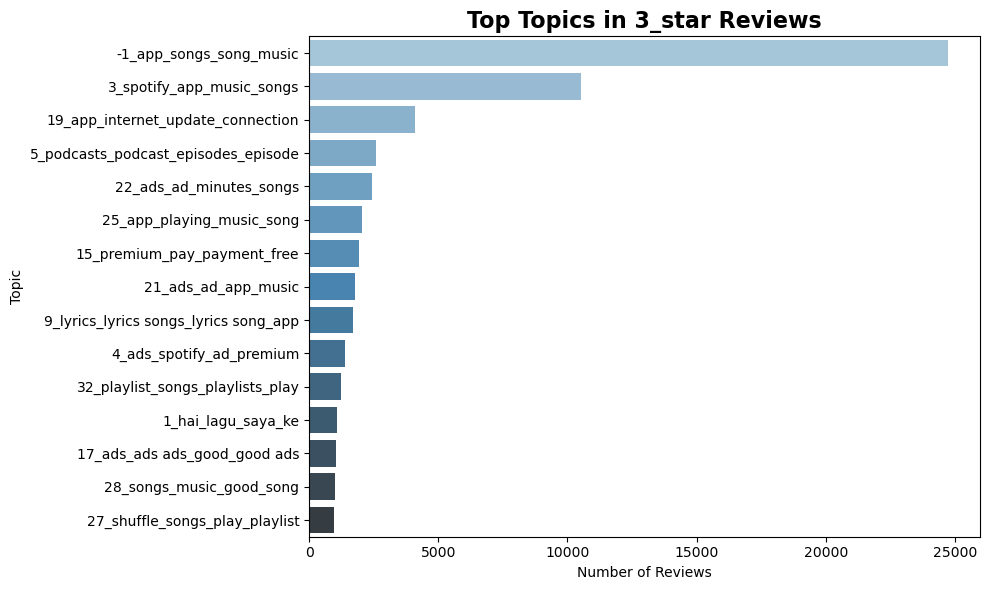

In [4]:


topic_info = topic_model_mid.get_topic_info().sort_values("Count", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=topic_info.head(15),
    y="Name",
    x="Count",
    palette="Blues_d"
)

plt.title("Top Topics in 3_star Reviews", fontsize=16, weight="bold")
plt.xlabel("Number of Reviews")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()
